In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
from tqdm.notebook import tqdm
from colour_mappings import line_colours, line_names
from graph_loading import load_graph

In [2]:
G, pos, colors, weights, index_to_station_name, station_name_to_index = load_graph()

In [3]:
def find_multi_line_route(G, stops_per_line=1, min_lines=None):
    """
    Find a route that uses as many different lines as possible, taking a specified number of stops on each line.
    
    Parameters:
    - G: NetworkX MultiDiGraph
    - stops_per_line: Maximum number of stops allowed per line
    - min_lines: Minimum number of lines to use (optional)
    
    Returns:
    - path: List of (from_station, to_station, line) tuples
    """
    def find_route_from_start(current_station, line_usage, path):
        # If we've tried all possible next moves, return current best path
        best_path = path if len(path) > 0 else None
        
        # Try each possible next edge
        for next_station in G[current_station]:
            edges = G[current_station][next_station]
            for edge_id, edge_data in edges.items():
                line = edge_data['line']
                # Can use this line if we haven't maxed out its usage
                if line_usage.get(line, 0) < stops_per_line:
                    # Try this edge
                    new_usage = line_usage.copy()
                    new_usage[line] = new_usage.get(line, 0) + 1
                    
                    new_path = find_route_from_start(
                        next_station,
                        new_usage,
                        path + [(current_station, next_station, line)]
                    )
                    if new_path is not None:
                        if best_path is None or len(set(edge[2] for edge in new_path)) > len(set(edge[2] for edge in best_path)):
                            best_path = new_path
        return best_path

    # Try starting from each station
    best_overall_path = None
    for start in G.nodes():
        path = find_route_from_start(start, {}, [])
        if path is not None:
            if best_overall_path is None or len(set(edge[2] for edge in path)) > len(set(edge[2] for edge in best_overall_path)):
                best_overall_path = path
                print(f"Found new best path ({len(path)} edges) using {len(set(edge[2] for edge in path))} lines")
                
        # If we found a path meeting minimum line requirement, we can stop
        if min_lines is not None and best_overall_path is not None and len(set(edge[2] for edge in best_overall_path)) >= min_lines:
            break
    
    return best_overall_path

In [4]:
route = find_multi_line_route(G,stops_per_line=1)

Found new best path (1 edges) using 1 lines
Found new best path (2 edges) using 2 lines
Found new best path (3 edges) using 3 lines
Found new best path (11 edges) using 11 lines
Found new best path (14 edges) using 14 lines


Found a route using 14 different lines!

Route:
1. Finchley Road -> Baker Street (Metropolitan Line)
2. Baker Street -> Edgware Road Circle/District/H&C (Hammersmith and City Line)
3. Edgware Road Circle/District/H&C -> Paddington (Circle Line)
4. Paddington -> Bond Street (Elizabeth Line)
5. Bond Street -> Oxford Circus (Central Line)
6. Oxford Circus -> Green Park (Victoria Line)
7. Green Park -> Piccadilly Circus (Piccadilly Line)
8. Piccadilly Circus -> Charing Cross (Bakerloo Line)
9. Charing Cross -> Embankment (Northern Line)
10. Embankment -> Westminster (District Line)
11. Westminster -> Waterloo (Jubilee Line)
12. Waterloo -> Bank (Waterloo and City Line)
13. Bank -> Shadwell (DLR)
14. Shadwell -> Whitechapel (Overground)


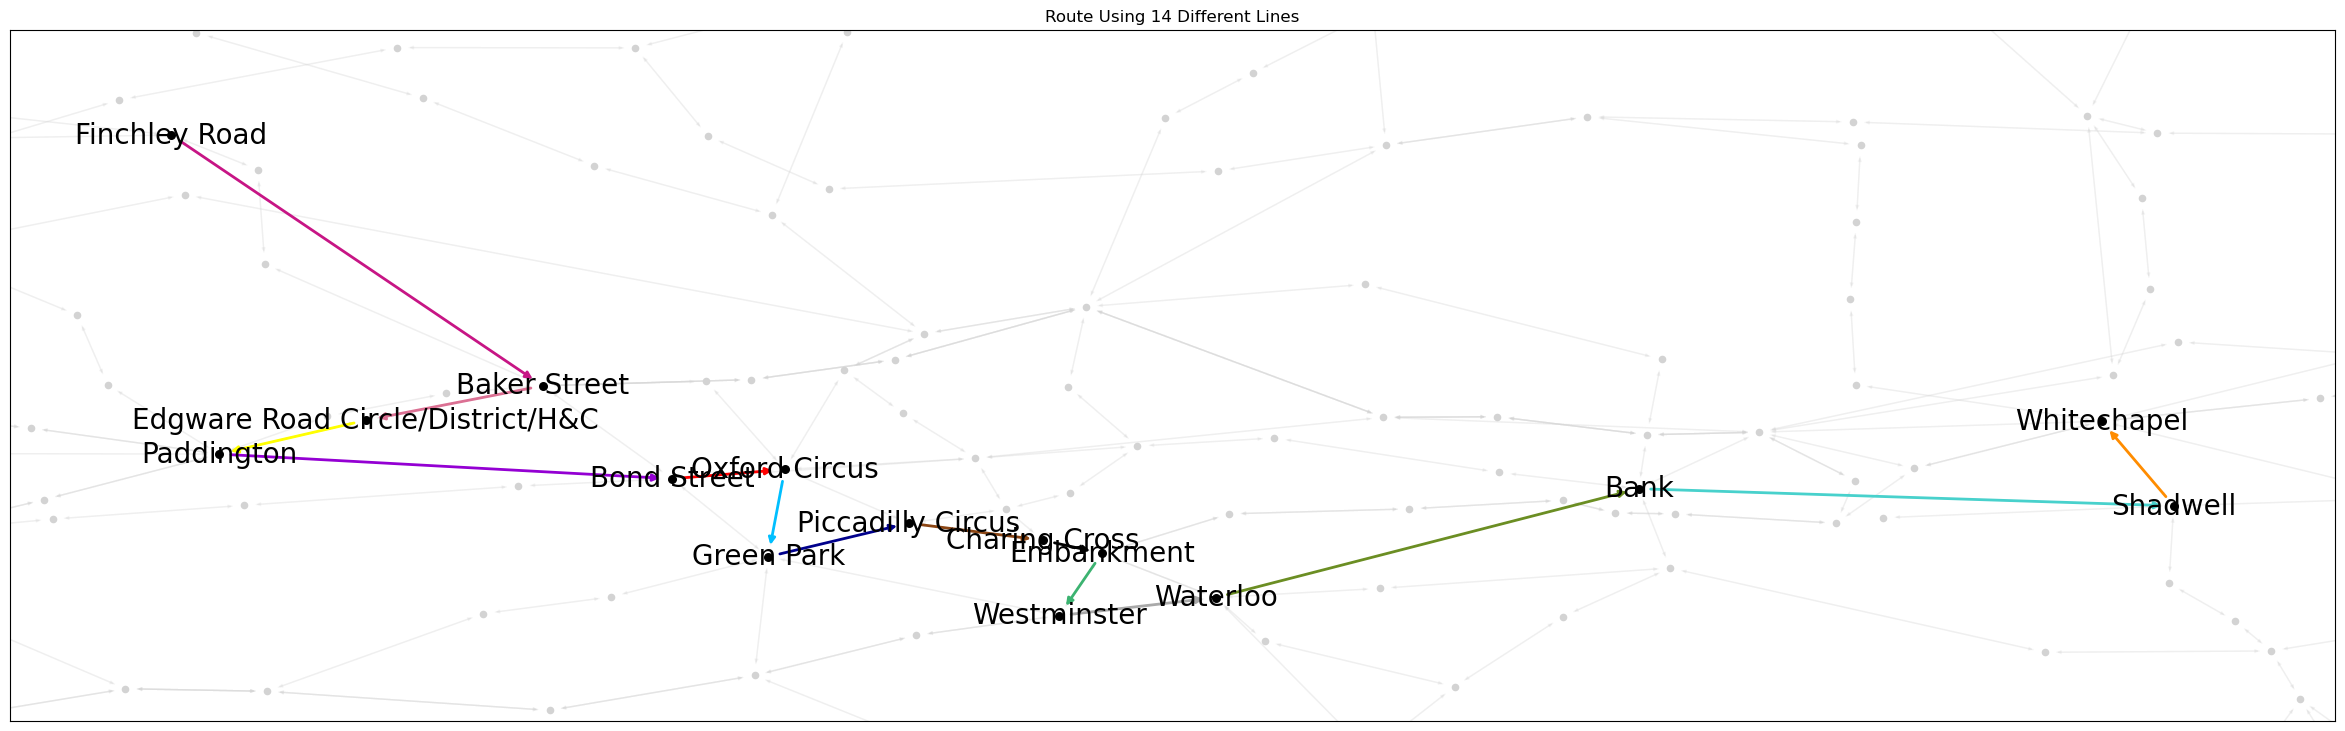

In [5]:
print(f"Found a route using {len(route)} different lines!")
print("\nRoute:")
for i, (start, end, line) in enumerate(route):
    print(f"{i+1}. {index_to_station_name[start]} -> {index_to_station_name[end]} ({line})")

# Visualize the route
x_coords = [coord[0] for coord in pos.values()]
y_coords = [coord[1] for coord in pos.values()]
x_min, x_max = min(x_coords), max(x_coords)
y_min, y_max = min(y_coords), max(y_coords)

# Calculate aspect ratio
width = x_max - x_min
height = y_max - y_min
aspect_ratio = width / height
plt.figure(figsize=(30,30/aspect_ratio))

# Draw all edges in light grey first
for u, v, k, data in G.edges(data=True, keys=True):
    nx.draw_networkx_edges(G,
                            pos,
                            edgelist=[(u,v)],
                            edge_color='lightgrey',
                            alpha=0.2,
                            arrowsize=5,
                            arrowstyle='-|>')
    
nx.draw_networkx_nodes(G, pos, 
                        node_color='lightgrey',
                        node_size=20)

# Draw the route edges in their proper colors
stations_in_route = []
for start, end, line in route:
    stations_in_route.extend([start, end])
    nx.draw_networkx_edges(G,
                            pos,
                            edgelist=[(start, end)],
                            edge_color=[line_colours[line]],
                            width=2,
                            arrowsize=10,
                            arrowstyle='-|>')

# Draw and label route stations
stations_in_route = list(dict.fromkeys(stations_in_route))  # Remove duplicates while preserving order
route_labels = {node: index_to_station_name[node] for node in stations_in_route}

# Draw all stations in route
nx.draw_networkx_nodes(G, pos, 
                        nodelist=stations_in_route,
                        node_color='black',
                        node_size=30)

nx.draw_networkx_labels(G, pos, 
                        labels=route_labels,
                        font_size=20)

x_coords = [pos[station][0] for station in stations_in_route]
y_coords = [pos[station][1] for station in stations_in_route]

# Calculate the bounds with some padding
x_min, x_max = min(x_coords), max(x_coords)
y_min, y_max = min(y_coords), max(y_coords)
padding = 0.01  # Adjust this value to change the padding around the route

plt.xlim(x_min - padding, x_max + padding)
plt.ylim(y_min - padding, y_max + padding)

plt.title(f"Route Using {len(route)} Different Lines")
plt.show()

Animated Variant of Above

In [6]:
class ProgressAnimation:
    def __init__(self, fig, update_func, frames, interval=50):
        self.progress_bar = tqdm(total=len(frames))
        
        def wrapped_update(frame_num, *args):
            # Update progress bar
            self.progress_bar.n = frame_num
            self.progress_bar.refresh()
            
            # Call the original update function
            result = update_func(frame_num, *args)
            
            # Close progress bar when animation is complete
            if frame_num == len(frames) - 1:
                self.progress_bar.close()
                
            return result
        
        self.anim = animation.FuncAnimation(
            fig,
            wrapped_update,
            frames=frames,
            interval=interval,
            repeat=False
        )

In [ ]:
def find_multi_line_route_with_animation(G, stops_per_line=1, min_lines=None):
    exploration_history = []
    current_best_path = None
    
    def find_route_from_start(current_station, line_usage, path):
        nonlocal current_best_path
        exploration_history.append({
            'path': path.copy(),
            'is_best': False,
            'best_path': current_best_path.copy() if current_best_path else None
        })
        
        best_path = path if len(path) > 0 else None
        
        for next_station in G[current_station]:
            edges = G[current_station][next_station]
            for edge_id, edge_data in edges.items():
                line = edge_data['line']
                if line_usage.get(line, 0) < stops_per_line:
                    new_usage = line_usage.copy()
                    new_usage[line] = new_usage.get(line, 0) + 1
                    
                    new_path = find_route_from_start(
                        next_station,
                        new_usage,
                        path + [(current_station, next_station, line)]
                    )
                    if new_path is not None:
                        if best_path is None or len(set(edge[2] for edge in new_path)) > len(set(edge[2] for edge in best_path)):
                            best_path = new_path
                            if (current_best_path is None or 
                                len(set(edge[2] for edge in best_path)) > len(set(edge[2] for edge in current_best_path))):
                                current_best_path = best_path.copy()
                                exploration_history.append({
                                    'path': best_path.copy(),
                                    'is_best': True,
                                    'best_path': current_best_path.copy()
                                })
        return best_path

    best_overall_path = None
    for start in tqdm(list(G.nodes()), desc="Exploring starting stations"):
        path = find_route_from_start(start, {}, [])
        if path is not None:
            if best_overall_path is None or len(set(edge[2] for edge in path)) > len(set(edge[2] for edge in best_overall_path)):
                best_overall_path = path
                print(f"\nFound new best path ({len(path)} edges) using {len(set(edge[2] for edge in path))} lines")
                
        if min_lines is not None and best_overall_path is not None and len(set(edge[2] for edge in best_overall_path)) >= min_lines:
            break
    
    return best_overall_path, exploration_history

def create_route_finding_animation(G, exploration_history):
    fig, ax = plt.subplots(figsize=(20, 15))
    
    def update(frame):
        ax.clear()
        
        # Get current path and calculate bounds
        current_path = exploration_history[frame]['path']
        best_path = exploration_history[frame]['best_path']
        
        # Get stations in current paths for scaling
        stations_to_consider = set()
        if current_path:
            for start, end, _ in current_path:
                stations_to_consider.add(start)
                stations_to_consider.add(end)
        if best_path:
            for start, end, _ in best_path:
                stations_to_consider.add(start)
                stations_to_consider.add(end)
        
        # Calculate plot bounds based on current stations
        if stations_to_consider:
            x_coords = [pos[station][0] for station in stations_to_consider]
            y_coords = [pos[station][1] for station in stations_to_consider]
            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)
            
            # Add margin based on the size of the current view
            x_margin = (x_max - x_min) * 0.1
            y_margin = (y_max - y_min) * 0.1
            
            plt.xlim(x_min - x_margin, x_max + x_margin)
            plt.ylim(y_min - y_margin, y_max + y_margin)
        
        # Draw all edges in light grey
        for u, v, k, data in G.edges(data=True, keys=True):
            nx.draw_networkx_edges(G,
                                 pos,
                                 ax=ax,
                                 edgelist=[(u,v)],
                                 edge_color='lightgrey',
                                 alpha=0.2,
                                 arrowsize=5,
                                 arrowstyle='-|>')
        
        is_best = exploration_history[frame]['is_best']
        
        # Draw current exploration path
        stations_in_path = []
        for start, end, line in current_path:
            stations_in_path.extend([start, end])
            nx.draw_networkx_edges(G,
                                 pos,
                                 ax=ax,
                                 edgelist=[(start, end)],
                                 edge_color=['red'],
                                 width=2,
                                 arrowsize=10,
                                 arrowstyle='-|>')
        
        # Draw best path found so far
        if best_path:
            for start, end, line in best_path:
                nx.draw_networkx_edges(G,
                                     pos,
                                     ax=ax,
                                     edgelist=[(start, end)],
                                     edge_color=[line_colours[line]],
                                     width=2,
                                     alpha=0.5,
                                     arrowsize=10,
                                     arrowstyle='-|>')
        
        # Draw stations
        stations_in_path = list(dict.fromkeys(stations_in_path))
        if stations_in_path:
            nx.draw_networkx_nodes(G, pos,
                                 ax=ax,
                                 nodelist=stations_in_path,
                                 node_color='black',
                                 node_size=50)
            
            # Label stations
            labels = {node: index_to_station_name[node] for node in stations_in_path}
            nx.draw_networkx_labels(G, pos,
                                  ax=ax,
                                  labels=labels,
                                  font_size=8)
        
        # Add information text
        current_lines = len(set(edge[2] for edge in current_path)) if current_path else 0
        best_lines = len(set(edge[2] for edge in best_path)) if best_path else 0
        plt.title(f"Step {frame+1}/{len(exploration_history)}\n"
                 f"Current path: {current_lines} lines, {len(current_path)} edges\n"
                 f"Best path so far: {best_lines} lines\n"
                 f"{'NEW BEST PATH!' if is_best else ''}")
    
    frames = range(len(exploration_history))
    print(f"\nCreating animation with {frames} frames...")
    anim = ProgressAnimation(fig, update, frames, interval=50)
    
    return anim

def sample_exploration_history(history, target_frames=1200):
    """
    Sample frames from exploration history to create a shorter animation.
    Ensures we keep important frames (where new best paths are found).
    """
    if len(history) <= target_frames:
        return history
    
    # Always keep frames where we find a new best path
    important_indices = [i for i, frame in enumerate(history) if frame['is_best']]
    
    # Calculate how many regular frames we can include
    remaining_frames = target_frames - len(important_indices)
    
    # Calculate sampling interval for regular frames
    total_regular_frames = len(history) - len(important_indices)
    if total_regular_frames > 0:
        sampling_interval = max(1, total_regular_frames // remaining_frames)
    else:
        sampling_interval = 1

    # Get indices of regular frames to include
    regular_indices = [i for i in range(0, len(history), sampling_interval) 
                      if i not in important_indices][:remaining_frames]
    
    # Combine and sort all indices
    selected_indices = sorted(set(important_indices + regular_indices))
    
    # Create new sampled history
    sampled_history = [history[i] for i in selected_indices]
    
    return sampled_history

def create_route_finding_animation(G, exploration_history, target_duration_seconds=60):
    # Sample the exploration history
    frames_per_second = 20  # A reasonable frame rate
    target_frames = frames_per_second * target_duration_seconds
    sampled_history = sample_exploration_history(exploration_history, target_frames)
    
    fig, ax = plt.subplots(figsize=(20, 15))
    
    def update(frame):
        ax.clear()
        
        # Get current path and calculate bounds
        current_path = sampled_history[frame]['path']
        best_path = sampled_history[frame]['best_path']
        is_best = sampled_history[frame]['is_best']
        
        # Get stations in current paths for scaling
        stations_to_consider = set()
        if current_path:
            for start, end, _ in current_path:
                stations_to_consider.add(start)
                stations_to_consider.add(end)
        if best_path:
            for start, end, _ in best_path:
                stations_to_consider.add(start)
                stations_to_consider.add(end)
        
        # Calculate plot bounds based on current stations
        if stations_to_consider:
            x_coords = [pos[station][0] for station in stations_to_consider]
            y_coords = [pos[station][1] for station in stations_to_consider]
            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)
            
            # Add margin based on the size of the current view
            x_margin = (x_max - x_min) * 0.1
            y_margin = (y_max - y_min) * 0.1
            
            plt.xlim(x_min - x_margin, x_max + x_margin)
            plt.ylim(y_min - y_margin, y_max + y_margin)
        
        # Draw all edges in light grey
        for u, v, k, data in G.edges(data=True, keys=True):
            nx.draw_networkx_edges(G,
                                 pos,
                                 ax=ax,
                                 edgelist=[(u,v)],
                                 edge_color='lightgrey',
                                 alpha=0.2,
                                 arrowsize=5,
                                 arrowstyle='-|>')
        
        # Draw current exploration path
        stations_in_path = []
        for start, end, line in current_path:
            stations_in_path.extend([start, end])
            nx.draw_networkx_edges(G,
                                 pos,
                                 ax=ax,
                                 edgelist=[(start, end)],
                                 edge_color=['red'],
                                 width=2,
                                 arrowsize=10,
                                 arrowstyle='-|>')
        
        # Draw best path found so far
        if best_path:
            for start, end, line in best_path:
                nx.draw_networkx_edges(G,
                                     pos,
                                     ax=ax,
                                     edgelist=[(start, end)],
                                     edge_color=[line_colours[line]],
                                     width=2,
                                     alpha=0.5,
                                     arrowsize=10,
                                     arrowstyle='-|>')
        
        # Draw stations
        stations_in_path = list(dict.fromkeys(stations_in_path))
        if stations_in_path:
            nx.draw_networkx_nodes(G, pos,
                                 ax=ax,
                                 nodelist=stations_in_path,
                                 node_color='black',
                                 node_size=50)
            
            # Label stations
            labels = {node: index_to_station_name[node] for node in stations_in_path}
            nx.draw_networkx_labels(G, pos,
                                  ax=ax,
                                  labels=labels,
                                  font_size=8)
        
        # Calculate current and best lines for title
        current_lines = len(set(edge[2] for edge in current_path)) if current_path else 0
        best_lines = len(set(edge[2] for edge in best_path)) if best_path else 0
        
        # Add information text
        plt.title(f"Exploring paths\n"
                 f"Current path: {current_lines} lines, {len(current_path)} edges\n"
                 f"Best path so far: {best_lines} lines\n"
                 f"{'NEW BEST PATH!' if is_best else ''}")
    
    # Calculate interval to achieve target duration
    interval = (target_duration_seconds * 1000) / len(sampled_history)
    
    print(f"\nCreating animation with {len(sampled_history)} frames...")
    anim = ProgressAnimation(fig, update, range(len(sampled_history)), interval=interval)
    
    return anim

# Usage remains the same
best_path, history = find_multi_line_route_with_animation(G, stops_per_line=1)

print(f"Original number of frames: {len(history)}")
anim = create_route_finding_animation(G, history, target_duration_seconds=60)

print("\nSaving animation...")
anim.anim.save('route_finding.gif', writer='pillow')
plt.close()


Exploring starting stations:   0%|          | 0/456 [00:00<?, ?it/s]